# Training with data from Kaggle New York Taxi data set

In [14]:
#load data 

import pandas as pd
import pickle
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

X_total = pickle.load(open('X_Kaggle', 'rb'))
Y_triptime = pickle.load(open('Y_Kaggle_triptime', 'rb'))

In [15]:
traingRecordNumber = len(X_total)
X = X_total.as_matrix()[0:traingRecordNumber,:]
print str(len(X))


y = np.log(Y_triptime.tolist()[0:traingRecordNumber])
print str(len(y))

1458644
1458644


In [16]:
X_total.columns

Index([u'weekday_0', u'weekday_1', u'weekday_2', u'weekday_3', u'weekday_4',
       u'weekday_5', u'weekday_6', u'hourofday_0', u'hourofday_1',
       u'hourofday_2',
       ...
       u'dropoffLoc_40', u'dropoffLoc_41', u'dropoffLoc_42', u'dropoffLoc_43',
       u'dropoffLoc_44', u'dropoffLoc_45', u'dropoffLoc_46', u'dropoffLoc_47',
       u'dropoffLoc_48', u'dropoffLoc_49'],
      dtype='object', length=131)

# Trained with XGB

In [17]:
import xgboost as xgb

from sklearn.model_selection import train_test_split

#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(X, y, test_size=0.2, random_state=0)
Xcv,Xv,Zcv,Zv = train_test_split(Xval, Zval, test_size=0.5, random_state=1)
data_tr  = xgb.DMatrix(Xtrain, label=Ztrain)
data_cv  = xgb.DMatrix(Xcv   , label=Zcv)
evallist = [(data_tr, 'train'), (data_cv, 'valid')]

In [20]:
parms = {'max_depth':16, #maximum depth of a tree
         'objective':'reg:linear',
         'eta'      :0.1,
         'subsample':0.8,#SGD will use this percentage of data
         'lambda '  :1, #L2 regularization term,>1 more conservative 
         'colsample_bytree ':0.9,
         'colsample_bylevel':1,
         'min_child_weight': 10}  

model = xgb.train(parms, data_tr, num_boost_round=1000, evals = evallist,
                  early_stopping_rounds=30, maximize=False, 
                  verbose_eval=100)

print('score = %1.5f, n_boost_round =%d.'%(model.best_score,model.best_iteration))

[0]	train-rmse:5.42464	valid-rmse:5.42466
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[100]	train-rmse:0.526235	valid-rmse:0.532068
[200]	train-rmse:0.481522	valid-rmse:0.492689
[300]	train-rmse:0.469957	valid-rmse:0.484029
[400]	train-rmse:0.46562	valid-rmse:0.482075
[500]	train-rmse:0.463262	valid-rmse:0.48182
Stopping. Best iteration:
[488]	train-rmse:0.463483	valid-rmse:0.481781

score = 0.48178, n_boost_round =488.


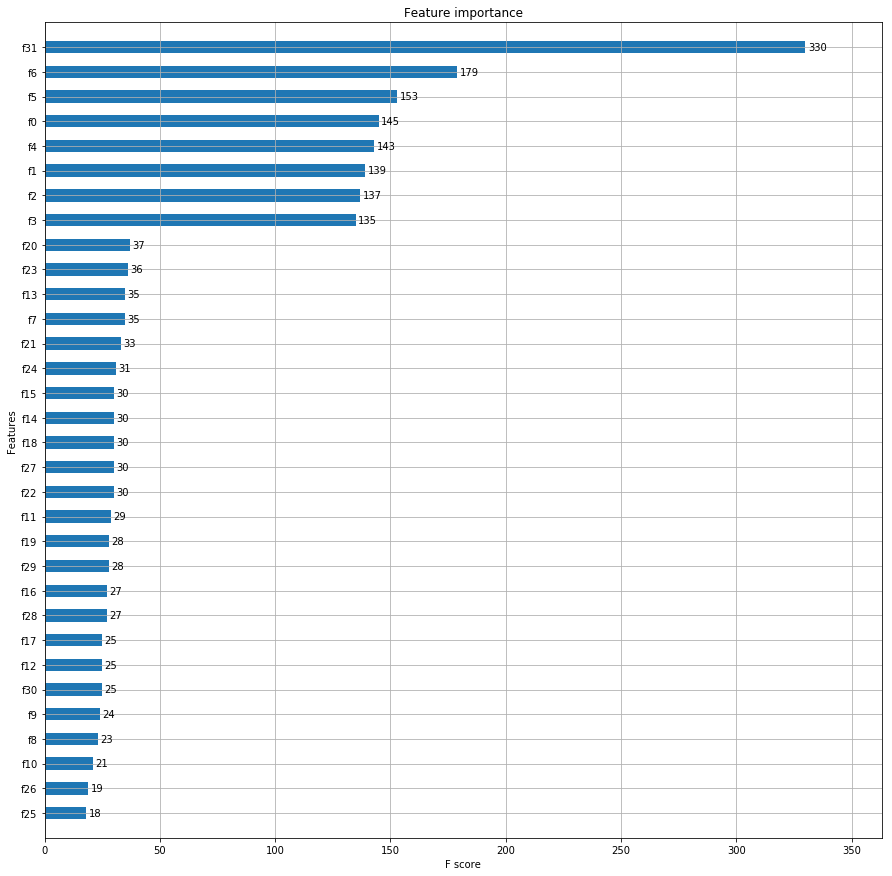

In [6]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
xgb.plot_importance(model,ax = axes,height =0.5)
plt.show();plt.close()

In [7]:
model = MLPRegressor(early_stopping=True,alpha=0.01)
#scores4 = cross_val_score(model, X2, y, cv=4,scoring='neg_mean_squared_error',n_jobs=-1)

param_grid = [
 {'hidden_layer_sizes': [(100,300),(100,100),(100,100,100)]},
 ]

clf2 = GridSearchCV(model, param_grid, cv=2,scoring='neg_mean_squared_error',
                       n_jobs=-1,verbose=10)

clf2.fit(X,y)

clf2.cv_results_

{'mean_fit_time': array([410.24872994, 332.67073405, 348.35069239, 521.7891835 ,
        402.49975145]),
 'mean_score_time': array([3.44220853, 2.56609952, 6.34001148, 2.9485116 , 5.03074062]),
 'mean_test_score': array([-0.23911376, -0.24441152, -0.24107524, -0.23799285, -0.24287572]),
 'mean_train_score': array([-0.23787689, -0.243739  , -0.2398655 , -0.23673519, -0.2420613 ]),
 'param_hidden_layer_sizes': masked_array(data=[(30, 20), (10, 10, 10), (100, 30), (100, 100),
                    (10, 10, 100)],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'hidden_layer_sizes': (30, 20)},
  {'hidden_layer_sizes': (10, 10, 10)},
  {'hidden_layer_sizes': (100, 30)},
  {'hidden_layer_sizes': (100, 100)},
  {'hidden_layer_sizes': (10, 10, 100)}],
 'rank_test_score': array([2, 5, 3, 1, 4], dtype=int32),
 'split0_test_score': array([-0.23968489, -0.24251326, -0.24408334, -0.23857632, -0.24324786]),
 'split0_train_score':

In [11]:
nn_model = MLPRegressor(early_stopping=True,alpha=0.1,hidden_layer_sizes=(100,100),verbose=True)
nn_model.fit(X,y)

Iteration 1, loss = 0.24327789
Validation score: 0.621100
Iteration 2, loss = 0.13476278
Validation score: 0.617791
Iteration 3, loss = 0.13147092
Validation score: 0.613714
Iteration 4, loss = 0.13043591
Validation score: 0.631784
Iteration 5, loss = 0.13008978
Validation score: 0.631495
Iteration 6, loss = 0.12968021
Validation score: 0.627201
Iteration 7, loss = 0.12948493
Validation score: 0.630137
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


MLPRegressor(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

#save the model for prediction

In [19]:

pickle.dump(model,open("model_Kaggle","wb"))